In [1]:
 !pip install -U accelerate
 !pip install -U transformers
 !pip install neptune

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 55.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2

In [2]:
import os
import random
import json
import shutil
import copy
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torchvision import models, datasets, transforms
from torchvision.models import ResNet34_Weights
import timm
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import ViTModel, ViTConfig, ViTForImageClassification
from transformers import BertForSequenceClassification, BertTokenizer, BertModel
import neptune as neptune
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
!unzip "/content/gdrive/My Drive/data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data/zalando/images/dresses/e03b51f96b3a4b8e9f2a84cb8f38cc66.jpg  
  inflating: __MACOSX/data/zalando/images/dresses/._e03b51f96b3a4b8e9f2a84cb8f38cc66.jpg  
  inflating: data/zalando/images/dresses/fa7b98039e2a4540bb5ba9372b34583b.jpg  
  inflating: __MACOSX/data/zalando/images/dresses/._fa7b98039e2a4540bb5ba9372b34583b.jpg  
  inflating: data/zalando/images/dresses/085fe4b6caf343c5a236bf006c9f0084.jpg  
  inflating: __MACOSX/data/zalando/images/dresses/._085fe4b6caf343c5a236bf006c9f0084.jpg  
  inflating: data/zalando/images/dresses/e66512169fd04aa2921efb1e2ea27c3d.jpg  
  inflating: __MACOSX/data/zalando/images/dresses/._e66512169fd04aa2921efb1e2ea27c3d.jpg  
  inflating: data/zalando/images/dresses/5632283a6553482592875335cc23c9f4.jpg  
  inflating: __MACOSX/data/zalando/images/dresses/._5632283a6553482592875335cc23c9f4.jpg  
  inflating: data/zalando/images/dresses/198061d8bb014c27a05a582a7396b55c.jpg  
  inflating: _

### 1. Data analysis


*   1.1 Here we'll take the Zalando dataset, visualize several examples from different classes and calculate basic statistics (example number, class distribution, etc.).

In [5]:
DEFAULT_RANDOM_SEED = 42

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# basic + torch
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

In [6]:
seedEverything()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load class names from the classes file
with open('data/zalando/meta/classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

# Load train and test splits
with open('data/zalando/meta/train.json') as f:
    train_data = json.load(f)
with open('data/zalando/meta/test.json') as f:
    test_data = json.load(f)

In [7]:
seedEverything()

train_samples = []
test_samples = []
for cls in classes:
    train_samples.extend([(f'data/zalando/images/{x}', x[0:x.find('/')]) for x in train_data[cls]])
    test_samples.extend([(f'data/zalando/images/{x}', x[0:x.find('/')]) for x in test_data[cls]])
print(f'Train size: {len(train_samples)}')
print(f'Test size: {len(test_samples)}')
print(train_samples[0:5])

Train size: 4500
Test size: 1500
[('data/zalando/images/coats/a538763f37e141f289d5bed2f07d56d2.jpg', 'coats'), ('data/zalando/images/coats/b821cfd1671a4a0c9bd55853c843932b.jpg', 'coats'), ('data/zalando/images/coats/3edd519610e243e98b0cc685c0dccc48.jpg', 'coats'), ('data/zalando/images/coats/ba14fc321b384bf59e9c97f7147257f6.jpg', 'coats'), ('data/zalando/images/coats/c0f82d18209a4b479e0202c4bef66289.jpg', 'coats')]


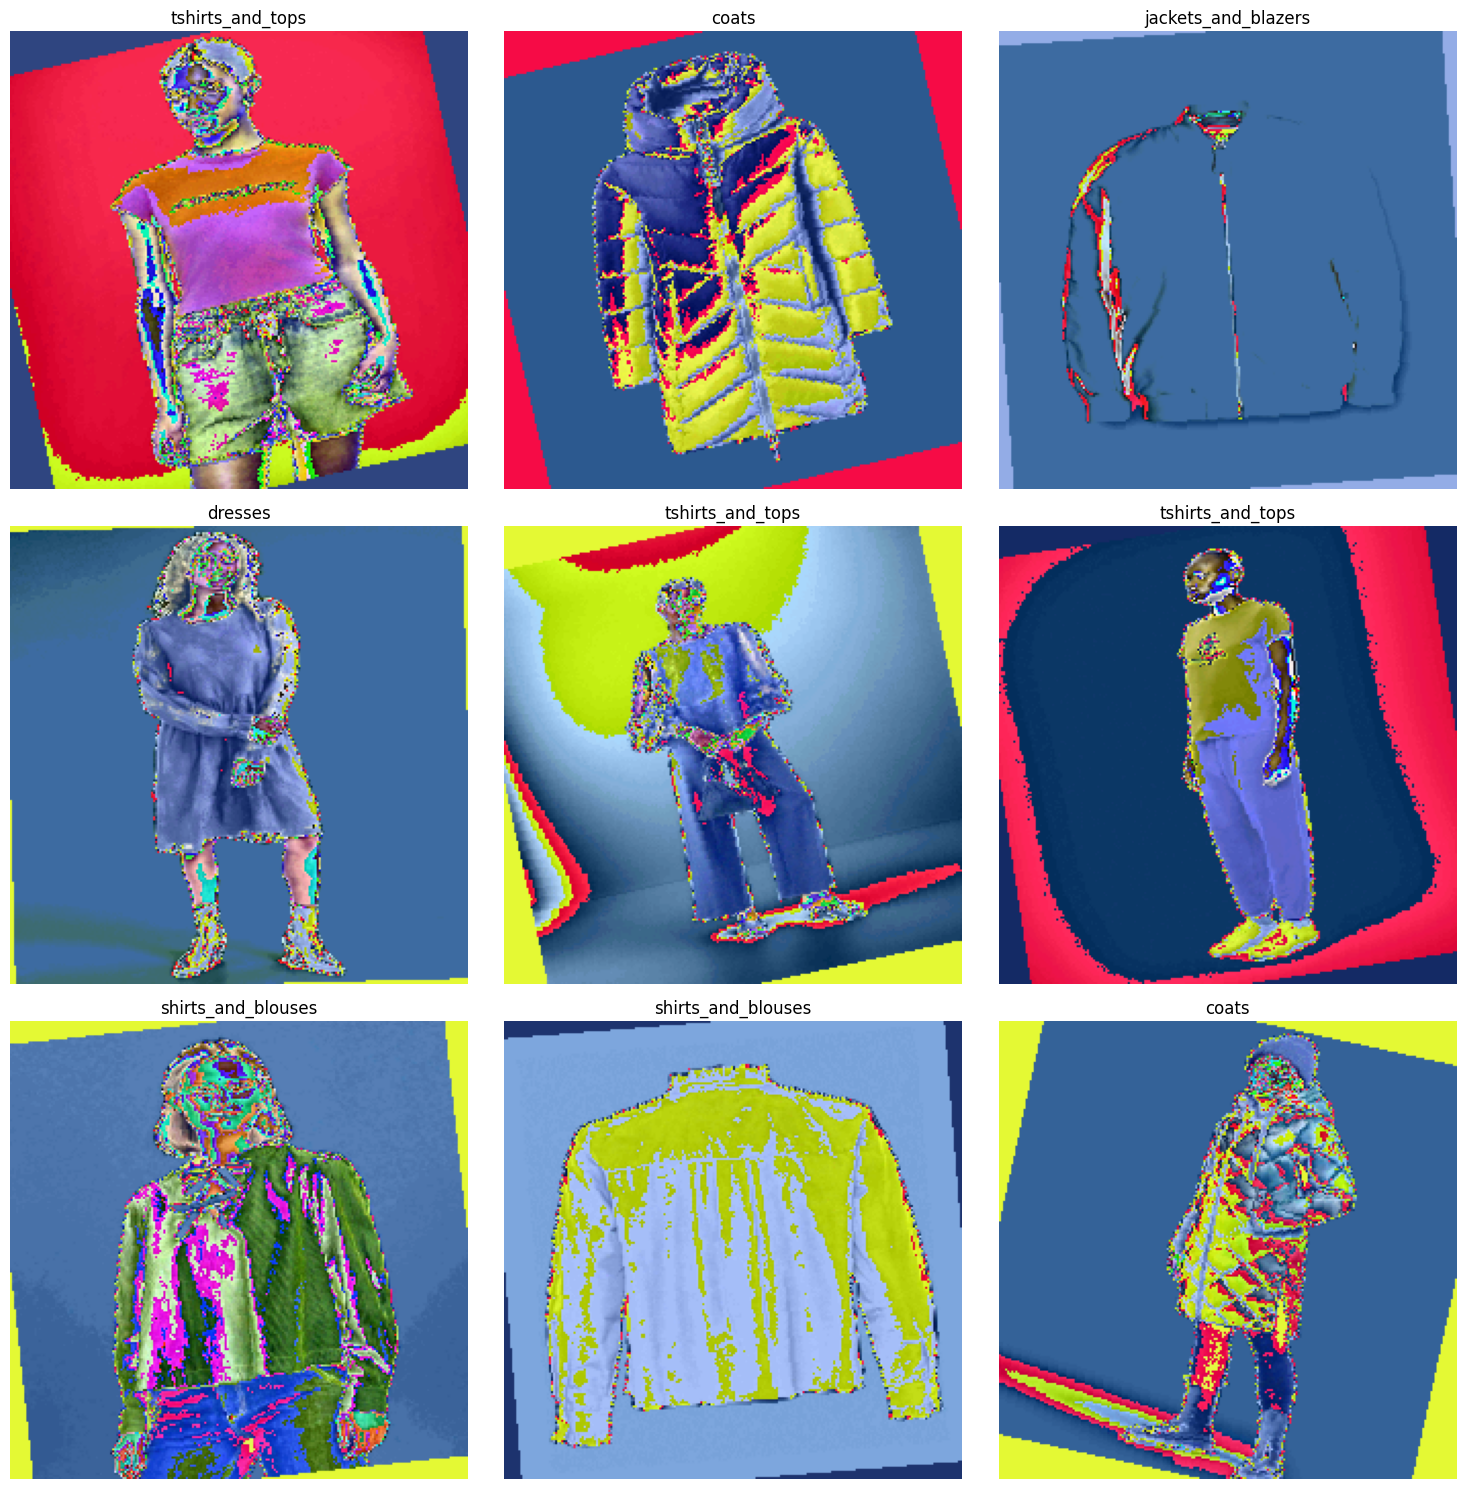

In [8]:
seedEverything()

def load_image(image_path, label):
    img = datasets.folder.default_loader(image_path)
    img = transform(img)
    return img, label

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    cls = random.choice(classes)
    image_name = random.choice(train_data[cls] + test_data[cls])
    image_path = f'data/zalando/images/{image_name}'
    img, label = load_image(image_path, cls)
    ax.imshow(transforms.ToPILImage()(img))
    ax.set_title(cls)
    ax.axis('off')

plt.tight_layout()
plt.show()

* Now let's calculate basic statistics for our selected classes and visualize it:

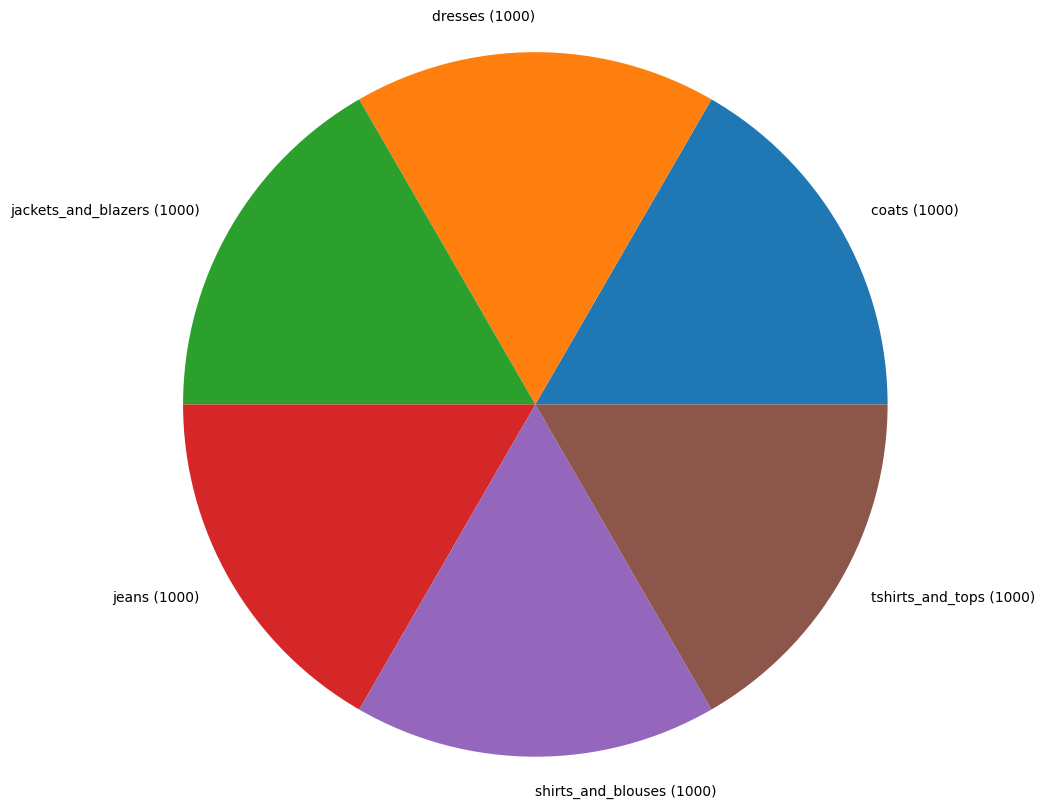

In [9]:
seedEverything()
labels = []
sizes = []

for class_name in classes:
    images = os.listdir(f'data/zalando/images/{class_name}')
    n = len(images)
    labels.append(f'{class_name} ({n})')
    sizes.append(n)

plt.figure(figsize=(10, 10))
plt.pie(sizes, labels=labels)
plt.axis('equal')
plt.show()

*   1.2 Let's split the data from train into current_train and current_val (val_size = 10%) and fix random_state for reproducibility.

In [10]:
seedEverything()

# Create a custom dataset
class CustomZalandoDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transform=None):
        self.samples = copy.deepcopy(samples)
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        label_index = classes.index(label)
        image = datasets.folder.default_loader(image_path)  # Load image
        if self.transform:
            image = self.transform(image)  # Apply transformations
        return image, label_index

# Initialize the custom dataset
train_dataset = CustomZalandoDataset(train_samples, transform=transform)
test_dataset = CustomZalandoDataset(test_samples, transform=transform)

# Splitting the dataset into current_train and current_val
total_train_count = len(train_dataset)
val_count = int(total_train_count * 0.1)  # 10% for validation
train_count = total_train_count - val_count  # Remaining for training
current_train, current_val = torch.utils.data.random_split(train_dataset, [train_count, val_count], generator=torch.Generator().manual_seed(42))

# Data loaders for both subsets
train_loader = torch.utils.data.DataLoader(current_train, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(current_val, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f'Size of the train dataset before the split: {total_train_count}')
print(f'Size of the val dataset: {val_count}')
print(f'Size of the train dataset after the split: {train_count}')
print(f'Size of the test dataset: {len(test_dataset)}')

Size of the train dataset before the split: 4500
Size of the val dataset: 450
Size of the train dataset after the split: 4050
Size of the test dataset: 1500


In [11]:
NUM_EPOCHS = 5

### 2. ResNet Fine-tuning
* 2.1   Let's take pre-trained [ResNet](https://pytorch.org/vision/main/models/resnet.html) from torchvision.

In [12]:
seedEverything()

# Training ResNet34
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Load pre-trained ResNet34 model
weights = ResNet34_Weights.IMAGENET1K_V1
resnet34 = models.resnet34(weights=weights)

# Modify the classifier to fit the number of classes (6)
num_ftrs = resnet34.fc.in_features
resnet34.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet34.fc.in_features, 6)
)
resnet34 = resnet34.to(device)

cuda


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 147MB/s]


In [13]:
seedEverything()

# Model training function
def train_model(model, model_name, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")

        for inputs, labels in train_progress:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs.logits if model_name == "ViT" else outputs, 1)
            loss = criterion(outputs.logits if model_name == "ViT" else outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            train_progress.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")

        with torch.no_grad():
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs.logits if model_name == "ViT" else outputs, 1)
                loss = criterion(outputs.logits if model_name == "ViT" else outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

                val_progress.set_postfix(loss=loss.item())

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save and log model
    model_path = f"{model_name}.pth"
    torch.save(model.state_dict(), model_path)

    return model

* 2.2   Now we'll fine-tune pre-trained ResNet on `current_train` created in 1.2 and validate it on `current_val` created in 1.2 in process of training. Let's also track our experiments using Neptune.

In [14]:
seedEverything()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet34.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)

trained_resnet34 = train_model(resnet34, "ResNet34", criterion, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS)

Epoch 1/5 [Validation]: 100%|██████████| 29/29 [00:33<00:00,  1.16s/it, loss=0.285]


Epoch 1/5, Train Loss: 1.1867, Train Acc: 0.5417, Val Loss: 0.7587, Val Acc: 0.6956


Epoch 2/5 [Validation]: 100%|██████████| 29/29 [00:32<00:00,  1.11s/it, loss=0.737]


Epoch 2/5, Train Loss: 0.8036, Train Acc: 0.7037, Val Loss: 0.6892, Val Acc: 0.7178


Epoch 3/5 [Validation]: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it, loss=0.481]


Epoch 3/5, Train Loss: 0.6808, Train Acc: 0.7496, Val Loss: 0.6118, Val Acc: 0.7467


Epoch 4/5 [Validation]: 100%|██████████| 29/29 [00:32<00:00,  1.13s/it, loss=0.403]


Epoch 4/5, Train Loss: 0.5751, Train Acc: 0.7830, Val Loss: 0.6493, Val Acc: 0.7467


Epoch 5/5 [Validation]: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it, loss=0.0988]


Epoch 5/5, Train Loss: 0.5109, Train Acc: 0.8141, Val Loss: 0.7328, Val Acc: 0.7578


* 2.3   Now let's evaluate our fine-tuned model (we'll use accuracy metric and data from test part for the evaluation).

In [15]:
seedEverything()

def plot_confusion_matrix(all_labels, all_preds, model_name, classes, cmap='viridis'):
    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Normalize
    cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the matrix
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    fig.colorbar(im, ax=ax, label='Proportion')

    # Configure ticks and labels
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticklabels(classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{model_name} - Normalized Confusion Matrix')

    # Add the text annotations in each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = 'black' if i == j else 'yellow'
            ax.text(j, i, f'{cm_normalized[i, j]:.2f}', ha='center', va='center', color=text_color)

    fig.tight_layout()
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.show()
    plt.close(fig)

In [16]:
seedEverything()

# Shared evaluation function for models
def evaluate_model(model, model_name, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.logits if model_name == "ViT" else outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    micro_f1 = f1_score(all_labels, all_preds, average='micro')
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"{model_name} Test Accuracy: {accuracy * 100:.2f}%")
    print(f"{model_name} Macro F1 Score: {macro_f1:.4f}")
    print(f"{model_name} Micro F1 Score: {micro_f1:.4f}")
    print(f"{model_name} Weighted F1 Score: {weighted_f1:.4f}")
    print()
    print(f"{model_name} Test Accuracy: {accuracy * 100:.2f}%")

    plot_confusion_matrix(all_labels, all_preds,model_name, classes)

    return accuracy * 100, macro_f1, micro_f1, weighted_f1

Evaluating ResNet34...
ResNet34 Test Accuracy: 77.00%
ResNet34 Macro F1 Score: 0.7627
ResNet34 Micro F1 Score: 0.7700
ResNet34 Weighted F1 Score: 0.7627

ResNet34 Test Accuracy: 77.00%


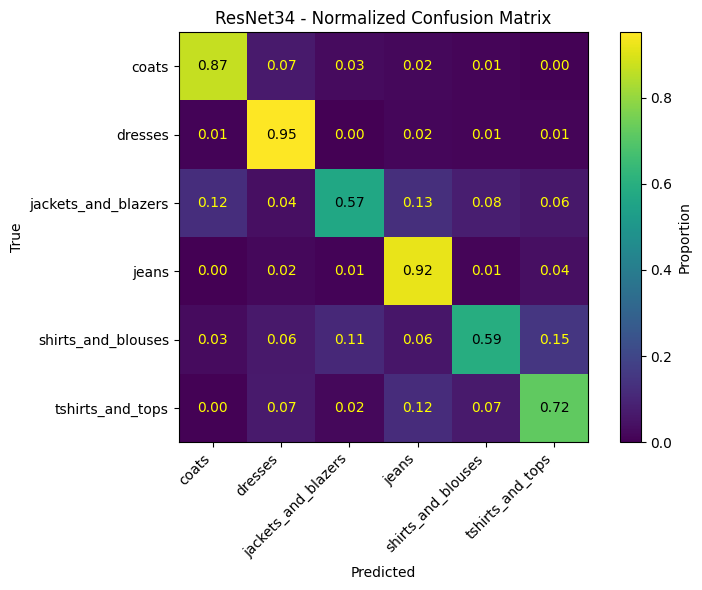

In [17]:
print("Evaluating ResNet34...")
resnet34_accuracy = evaluate_model(trained_resnet34, "ResNet34", test_loader)

### 3. VGG16 Fine-tuning


In [18]:
seedEverything()

transform_vgg16 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the custom dataset
train_dataset = CustomZalandoDataset(train_samples, transform=transform_vgg16)
test_dataset = CustomZalandoDataset(test_samples, transform=transform_vgg16)

# Splitting the dataset into current_train and current_val
total_train_count = len(train_dataset)
val_count = int(total_train_count * 0.1)
train_count = total_train_count - val_count
current_train, current_val = torch.utils.data.random_split(train_dataset, [train_count, val_count], generator=torch.Generator().manual_seed(42))

# Data loaders for both subsets
train_loader = torch.utils.data.DataLoader(current_train, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(current_val, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f'Size of the train dataset before the split: {total_train_count}')
print(f'Size of the val dataset: {val_count}')
print(f'Size of the train dataset after the split: {train_count}')
print(f'Size of the test dataset: {len(test_dataset)}')

Size of the train dataset before the split: 4500
Size of the val dataset: 450
Size of the train dataset after the split: 4050
Size of the test dataset: 1500


In [19]:
seedEverything()

# Training VGG16
# Load the VGG16 model pretrained on ImageNet
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Modify the classifier to fit the number of classes in your dataset
num_classes = 6
num_features = vgg16.classifier[-1].in_features
vgg16.classifier[-1] = nn.Linear(num_features, num_classes)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 168MB/s]


In [20]:
seedEverything()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

trained_vgg16 = train_model(vgg16, "VGG16", criterion, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS)

Epoch 1/5 [Validation]: 100%|██████████| 29/29 [00:30<00:00,  1.05s/it, loss=1.4]


Epoch 1/5, Train Loss: 0.9769, Train Acc: 0.6205, Val Loss: 0.7480, Val Acc: 0.7244


Epoch 2/5 [Validation]: 100%|██████████| 29/29 [00:31<00:00,  1.08s/it, loss=0.657]


Epoch 2/5, Train Loss: 0.6032, Train Acc: 0.7773, Val Loss: 0.6755, Val Acc: 0.7311


Epoch 3/5 [Validation]: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it, loss=1.08]


Epoch 3/5, Train Loss: 0.4268, Train Acc: 0.8440, Val Loss: 0.6803, Val Acc: 0.7578


Epoch 4/5 [Validation]: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it, loss=1.57]


Epoch 4/5, Train Loss: 0.3143, Train Acc: 0.8825, Val Loss: 0.6931, Val Acc: 0.7622


Epoch 5/5 [Validation]: 100%|██████████| 29/29 [00:27<00:00,  1.05it/s, loss=1.09]


Epoch 5/5, Train Loss: 0.1892, Train Acc: 0.9304, Val Loss: 0.8277, Val Acc: 0.7711


Evaluating VGG16...
VGG16 Test Accuracy: 77.87%
VGG16 Macro F1 Score: 0.7763
VGG16 Micro F1 Score: 0.7787
VGG16 Weighted F1 Score: 0.7763

VGG16 Test Accuracy: 77.87%


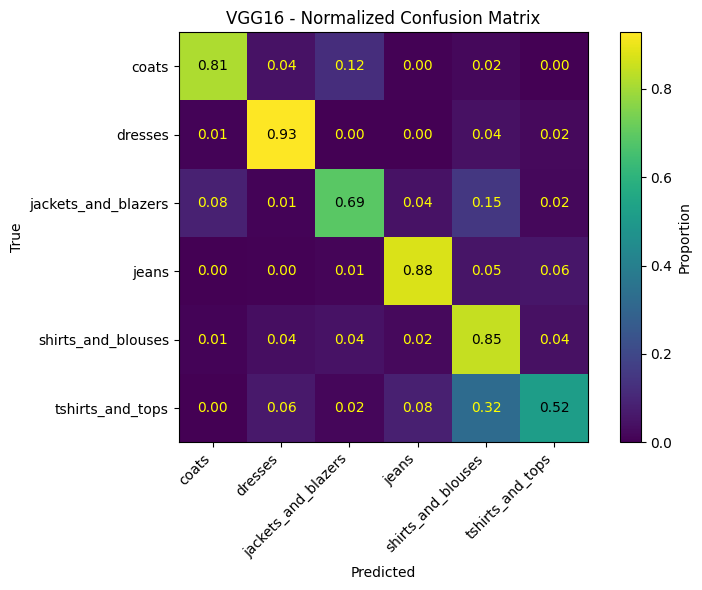

In [21]:
print("Evaluating VGG16...")
vgg16_accuracy = evaluate_model(trained_vgg16, "VGG16", test_loader)

### 4. DINOv2 Fine-tuning

In [22]:
seedEverything()

torch.cuda.empty_cache()

transform_dino = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the custom dataset
train_dataset = CustomZalandoDataset(train_samples, transform=transform_dino)
test_dataset = CustomZalandoDataset(test_samples, transform=transform_dino)

# Splitting the dataset into current_train and current_val
total_train_count = len(train_dataset)
val_count = int(total_train_count * 0.1)
train_count = total_train_count - val_count
current_train, current_val = torch.utils.data.random_split(train_dataset, [train_count, val_count], generator=torch.Generator().manual_seed(42))

# Data loaders for both subsets
train_loader = torch.utils.data.DataLoader(current_train, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(current_val, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f'Size of the train dataset before the split: {total_train_count}')
print(f'Size of the val dataset: {val_count}')
print(f'Size of the train dataset after the split: {train_count}')
print(f'Size of the test dataset: {len(test_dataset)}')

Size of the train dataset before the split: 4500
Size of the val dataset: 450
Size of the train dataset after the split: 4050
Size of the test dataset: 1500


In [23]:
from transformers import AutoModel, AutoImageProcessor, AutoModelForImageClassification
from transformers import Dinov2ForImageClassification
import gc

seedEverything()

gc.collect()
torch.cuda.empty_cache()
num_classes = 6

# Step 1: Load DINOv2 Model Pretrained on ImageNet
dino_v2_backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

for param in dino_v2_backbone.parameters():
    param.requires_grad = False  # Freeze backbone parameters

class DINOv2Classifier(nn.Module):
    def __init__(self, backbone, hidden_size, num_classes):
        super(DINOv2Classifier, self).__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Pass through the backbone
        embeddings = self.backbone(x)
        # Pass through the classification head
        logits = self.classifier(embeddings)
        return logits

# Adjust classifier
hidden_size = 384  # Hidden size for `dinov2_vits14`
dino_v2 = DINOv2Classifier(dino_v2_backbone, hidden_size, num_classes)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dino_v2 = dino_v2.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 211MB/s]


In [24]:
seedEverything()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(dino_v2.parameters(), lr=5e-4, weight_decay=1e-4)

trained_dino = train_model(dino_v2, "DINOv2", criterion, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS)

Epoch 1/5 [Validation]: 100%|██████████| 29/29 [00:31<00:00,  1.07s/it, loss=0.574]


Epoch 1/5, Train Loss: 0.8565, Train Acc: 0.6748, Val Loss: 0.6258, Val Acc: 0.7622


Epoch 2/5 [Validation]: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it, loss=0.464]


Epoch 2/5, Train Loss: 0.5690, Train Acc: 0.7847, Val Loss: 0.5782, Val Acc: 0.7578


Epoch 3/5 [Validation]: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it, loss=0.49]


Epoch 3/5, Train Loss: 0.5147, Train Acc: 0.8104, Val Loss: 0.5514, Val Acc: 0.7711


Epoch 4/5 [Validation]: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it, loss=0.358]


Epoch 4/5, Train Loss: 0.4938, Train Acc: 0.8160, Val Loss: 0.5691, Val Acc: 0.7756


Epoch 5/5 [Validation]: 100%|██████████| 29/29 [00:28<00:00,  1.01it/s, loss=0.306]


Epoch 5/5, Train Loss: 0.4699, Train Acc: 0.8277, Val Loss: 0.5678, Val Acc: 0.7911


Evaluating DINOv2...
DINOv2 Test Accuracy: 80.47%
DINOv2 Macro F1 Score: 0.7995
DINOv2 Micro F1 Score: 0.8047
DINOv2 Weighted F1 Score: 0.7995

DINOv2 Test Accuracy: 80.47%


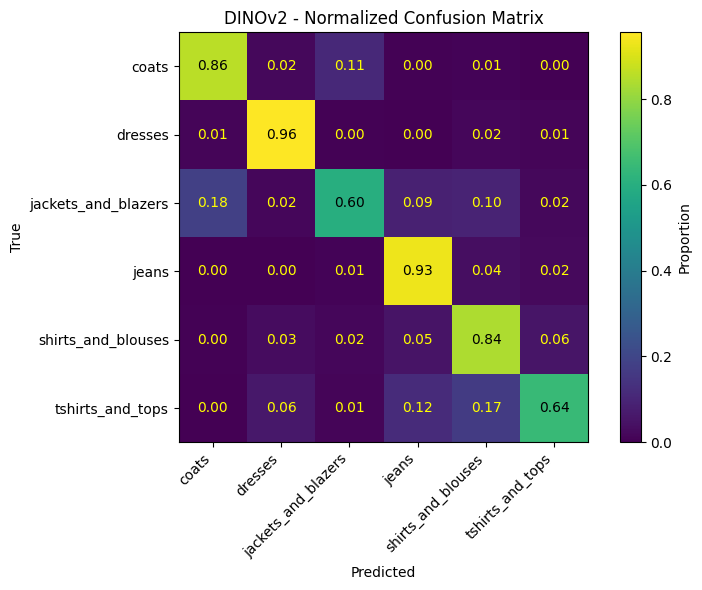

In [25]:
print("Evaluating DINOv2...")
dino_v2_accuracy = evaluate_model(trained_dino, "DINOv2", test_loader)

### 5. TNT (Transformer in Transformer)

In [26]:
seedEverything()

torch.cuda.empty_cache()

transform_tnt = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the custom dataset
train_dataset = CustomZalandoDataset(train_samples, transform=transform_tnt)
test_dataset = CustomZalandoDataset(test_samples, transform=transform_tnt)

# Splitting the dataset into current_train and current_val
total_train_count = len(train_dataset)
val_count = int(total_train_count * 0.1)
train_count = total_train_count - val_count
current_train, current_val = torch.utils.data.random_split(train_dataset, [train_count, val_count], generator=torch.Generator().manual_seed(42))

# Data loaders for both subsets
train_loader = torch.utils.data.DataLoader(current_train, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(current_val, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f'Size of the train dataset before the split: {total_train_count}')
print(f'Size of the val dataset: {val_count}')
print(f'Size of the train dataset after the split: {train_count}')
print(f'Size of the test dataset: {len(test_dataset)}')

Size of the train dataset before the split: 4500
Size of the val dataset: 450
Size of the train dataset after the split: 4050
Size of the test dataset: 1500


In [27]:
model_name = "tnt_s_patch16_224"  # Example: TNT-S model
tnt = timm.create_model(model_name, pretrained=True)

# Freeze all parameters in the TNT backbone
for param in tnt.parameters():
    param.requires_grad = False

# Ensure only the classification head is trainable
for param in tnt.head.parameters():
    param.requires_grad = True

# Modify the classifier to fit the number of classes
num_classes = 6  # Adjust for your dataset
hidden_features = tnt.head.in_features  # TNT's head input size
tnt.head = nn.Linear(hidden_features, num_classes)

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tnt = tnt.to(device)

Downloading: "https://github.com/contrastive/pytorch-image-models/releases/download/TNT/tnt_s_patch16_224.pth.tar" to /root/.cache/torch/hub/checkpoints/tnt_s_patch16_224.pth.tar


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(tnt.parameters(), lr=1e-3, weight_decay=1e-4)

# Train TNT model
trained_tnt = train_model(tnt, "TNT", criterion, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS)

Epoch 1/5 [Validation]: 100%|██████████| 29/29 [00:27<00:00,  1.06it/s, loss=1.37]


Epoch 1/5, Train Loss: 0.9968, Train Acc: 0.6232, Val Loss: 0.8658, Val Acc: 0.6667


Epoch 2/5 [Validation]: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s, loss=0.899]


Epoch 2/5, Train Loss: 0.7874, Train Acc: 0.7054, Val Loss: 0.8352, Val Acc: 0.6644


Epoch 3/5 [Validation]: 100%|██████████| 29/29 [00:27<00:00,  1.05it/s, loss=1.7]


Epoch 3/5, Train Loss: 0.7380, Train Acc: 0.7198, Val Loss: 0.7999, Val Acc: 0.6911


Epoch 4/5 [Validation]: 100%|██████████| 29/29 [00:28<00:00,  1.01it/s, loss=1.59]


Epoch 4/5, Train Loss: 0.6995, Train Acc: 0.7444, Val Loss: 0.7941, Val Acc: 0.7000


Epoch 5/5 [Validation]: 100%|██████████| 29/29 [00:27<00:00,  1.07it/s, loss=1.66]


Epoch 5/5, Train Loss: 0.6852, Train Acc: 0.7430, Val Loss: 0.7636, Val Acc: 0.7044


Evaluating TNT...
TNT Test Accuracy: 71.00%
TNT Macro F1 Score: 0.7074
TNT Micro F1 Score: 0.7100
TNT Weighted F1 Score: 0.7074

TNT Test Accuracy: 71.00%


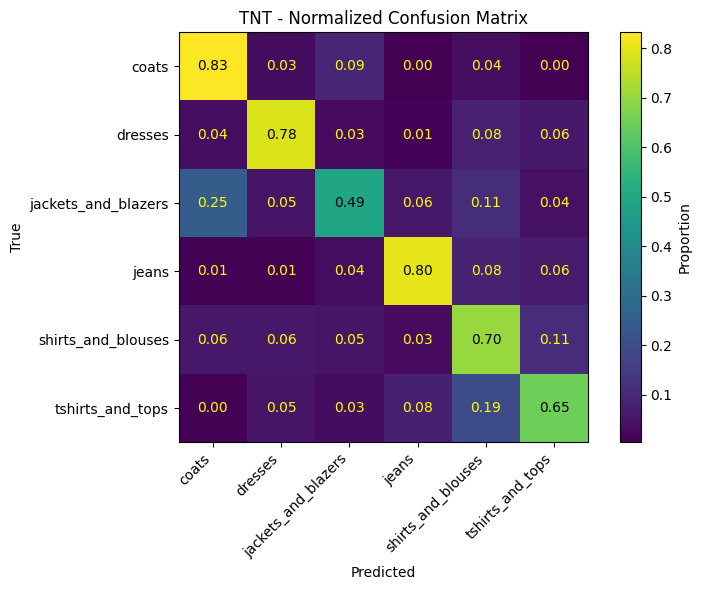

In [29]:
print("Evaluating TNT...")
tnt_accuracy = evaluate_model(trained_tnt, "TNT", test_loader)

### 6. Vit Fine-tuning
In this part we're going to fine-tune [ViT](https://huggingface.co/docs/transformers/model_doc/vit) model from HuggingFace library.

In [30]:
seedEverything()

transform_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the custom dataset
train_dataset = CustomZalandoDataset(train_samples, transform=transform_vit)
test_dataset = CustomZalandoDataset(test_samples, transform=transform_vit)

# Splitting the dataset into current_train and current_val
total_train_count = len(train_dataset)
val_count = int(total_train_count * 0.1)
train_count = total_train_count - val_count
current_train, current_val = torch.utils.data.random_split(train_dataset, [train_count, val_count], generator=torch.Generator().manual_seed(42))

# Data loaders for both subsets
train_loader = torch.utils.data.DataLoader(current_train, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(current_val, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f'Size of the train dataset before the split: {total_train_count}')
print(f'Size of the val dataset: {val_count}')
print(f'Size of the train dataset after the split: {train_count}')
print(f'Size of the test dataset: {len(test_dataset)}')

Size of the train dataset before the split: 4500
Size of the val dataset: 450
Size of the train dataset after the split: 4050
Size of the test dataset: 1500


In [31]:
seedEverything()

# Training ViT
vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=6)
vit_model = vit_model.to(device)

optimizer_vit = optim.SGD(vit_model.parameters(), lr=0.001, momentum=0.9)
trained_vit_model = train_model(vit_model, "ViT", criterion, optimizer_vit, train_loader, val_loader, num_epochs=NUM_EPOCHS)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/5 [Validation]: 100%|██████████| 29/29 [00:32<00:00,  1.13s/it, loss=1.03]


Epoch 1/5, Train Loss: 1.2586, Train Acc: 0.6454, Val Loss: 0.8004, Val Acc: 0.7778


Epoch 2/5 [Validation]: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it, loss=1.05]


Epoch 2/5, Train Loss: 0.6311, Train Acc: 0.8072, Val Loss: 0.5902, Val Acc: 0.7800


Epoch 3/5 [Validation]: 100%|██████████| 29/29 [00:32<00:00,  1.14s/it, loss=1.23]


Epoch 3/5, Train Loss: 0.4459, Train Acc: 0.8568, Val Loss: 0.5208, Val Acc: 0.7911


Epoch 4/5 [Validation]: 100%|██████████| 29/29 [00:30<00:00,  1.06s/it, loss=1.4]


Epoch 4/5, Train Loss: 0.3347, Train Acc: 0.8919, Val Loss: 0.4755, Val Acc: 0.8333


Epoch 5/5 [Validation]: 100%|██████████| 29/29 [00:30<00:00,  1.05s/it, loss=1.89]


Epoch 5/5, Train Loss: 0.3671, Train Acc: 0.8802, Val Loss: 0.5244, Val Acc: 0.7911


Evaluating ViT...
ViT Test Accuracy: 83.13%
ViT Macro F1 Score: 0.8284
ViT Micro F1 Score: 0.8313
ViT Weighted F1 Score: 0.8284

ViT Test Accuracy: 83.13%


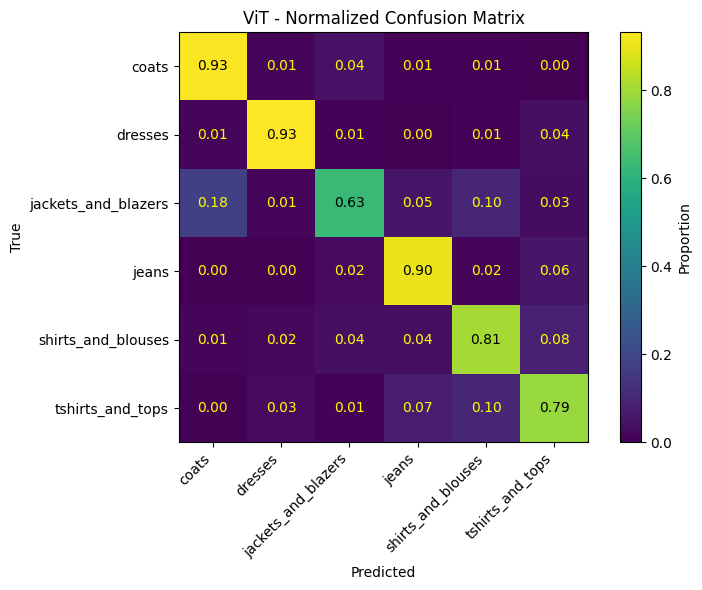

In [32]:
print("Evaluating ViT...")
vit_accuracy = evaluate_model(trained_vit_model, "ViT", test_loader)

### 7. Summary & results analysis

Let's Compare the results of the tested models:





In [33]:
print(f"ResNet34 Accuracy: {resnet34_accuracy[0]:.2f}%")
print(f"VGG16 Accuracy: {vgg16_accuracy[0]:.2f}%")
print(f"DINOv2 Accuracy: {dino_v2_accuracy[0]:.2f}%")
print(f"TNT Accuracy: {tnt_accuracy[0]:.2f}%")
print(f"ViT Accuracy: {vit_accuracy[0]:.2f}%")

ResNet34 Accuracy: 77.00%
VGG16 Accuracy: 77.87%
DINOv2 Accuracy: 80.47%
TNT Accuracy: 71.00%
ViT Accuracy: 83.13%
